<a href="https://colab.research.google.com/github/MariamMatar/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Dataset**

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import scipy as sc
from numpy import linalg
import scipy.io
from os import listdir

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def loadImages(path,folder_name):

  imgs = []   
  loadedMatFiles = []
  # path for train folder and another for validation  
  imagesList_train = listdir(path + '/train')   
  imagesList_val = listdir(path + '/val')  
  
  imagesList_train.sort()
  imagesList_val.sort()

                                                          
  if(folder_name == 'images'):
    for i in range(len(imagesList_train)):
      Img = mpimg.imread(path + '/train/' + imagesList_train[i])
      img = np.array(Img)                                                             
      imgs.append(img)   
    for i in range(len(imagesList_val)):
      Img = mpimg.imread(path + '/val/' + imagesList_val[i])                                                                 
      img = np.array(Img)                                                             
      imgs.append(img)   
  elif(folder_name == 'groundTruth'):
    for i in range(len(imagesList_train)):   
      mat = scipy.io.loadmat(path + '/train/' + imagesList_train[i]) 
      for j in range(0,mat['groundTruth'].shape[1]):      # looping on segments for each groundtruth
         imgs.append(mat['groundTruth'][0][j][0][0][0])    
                                              
    for i in range(len(imagesList_val)):
      mat = scipy.io.loadmat(path + '/val/' + imagesList_val[i])                                                                   
      for j in range(0,mat['groundTruth'].shape[1]):
         imgs.append(mat['groundTruth'][0][j][0][0][0])   
                          
  return imgs      
                          

In [ ]:
# loading the training images and Ground truth from Drive
training_imgs = loadImages('/content/drive/My Drive/BSR/BSR/BSDS500/data/images','images')
groundTruth = loadImages('/content/drive/My Drive/BSR/BSR/BSDS500/data/groundTruth','groundTruth') 

# **Visualize the image and the ground truth segmentation**

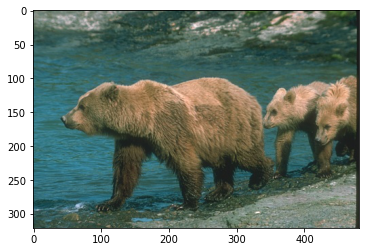

<Figure size 432x288 with 0 Axes>

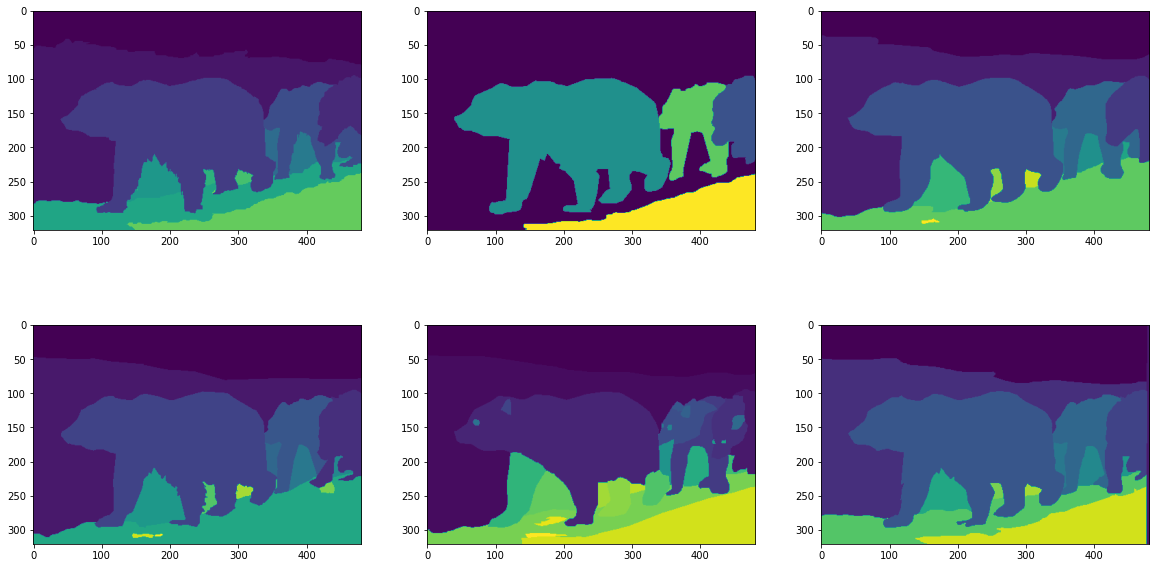

In [ ]:
# plotting image and it's Ground truth segmentation 
plt.imshow(training_imgs[0]);
plt.figure()
f, axarr = plt.subplots(2,3,figsize=(20,20))

axarr[0,0].imshow(groundTruth[0])
axarr[0,1].imshow(groundTruth[1])
axarr[0,2].imshow(groundTruth[2])
axarr[1,0].imshow(groundTruth[3])
axarr[1,1].imshow(groundTruth[4])
axarr[1,2].imshow(groundTruth[5])
plt.subplots_adjust(bottom=0.1,top=0.5)
plt.show()


# **Segmentation using K-means**

In [ ]:
import random
from copy import deepcopy
from scipy.spatial import distance

 
def Kmeans(K,Image,e,limit): 
 
  iter_num = 0
  float_img=np.float32(Image)
  scaled_image=float_img/255.0 #values between [0 1]
  pic_n = scaled_image.reshape(scaled_image.shape[0]*scaled_image.shape[1], scaled_image.shape[2])
  clusters = np.zeros(pic_n.shape[0]) 
  centroids = random.choices(pic_n[:], k=K)
  distances = np.zeros((pic_n.shape[0],K))
  old_centroids=np.zeros(np.shape(centroids))
  new_centroids=np.array(centroids)
  
  error = np.linalg.norm(new_centroids - old_centroids)

  while error > e and iter_num < limit:
    iter_num +=1
    for m in range(K):
      distances[:,m] = np.linalg.norm(pic_n - new_centroids[m], axis=1)
    clusters = np.argmin(distances, axis = 1)
    old_centroids = deepcopy(new_centroids)
      # Calculate mean for every cluster and update the center
    for i in range(K):  # loop on number of clusters
      if not pic_n[clusters == i].any():
        new_centroids =np.array( random.choices(pic_n[:], k=K))

        continue
        new_centroids[i] = np.mean(pic_n[clusters == i], axis=0)
    error = np.linalg.norm(new_centroids - old_centroids)        

  return clusters
 

 

**Cluster  color assignment**

In [ ]:

def ColorImages(clusters,data_mat,cluster_num):
    pic_n = data_mat.reshape(data_mat.shape[0]*data_mat.shape[1], data_mat.shape[2])#(321*481,3),(9600,3)
    clusterised_mat= np.zeros(pic_n.shape,dtype=np.uint8) 
    colors = []
    for i in range(cluster_num):
        colors.append(np.array([random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)]))
    
    for i in range(pic_n.shape[0]):
        clusterised_mat[i] = colors[clusters[i]]
    return clusterised_mat

In [ ]:
means=[3,5,7,9,11] #5 means
clustered_imgs=[]
Partitions=[]
# i=0 to i=4 for image 1
for j in range(len(training_imgs)):
  for i in range(len(means)):
   cluster = Kmeans(means[i],training_imgs[j],0.0001,300)
   cluster_img = ColorImages(cluster,training_imgs[j],means[i])
   Partitions.append(cluster)  #storing clusters for each k value per image [cluster for image(0) k=3,cluster for image(0) k=5,....]
   clustered_imgs.append(cluster_img)



**Display clustered images of one image**

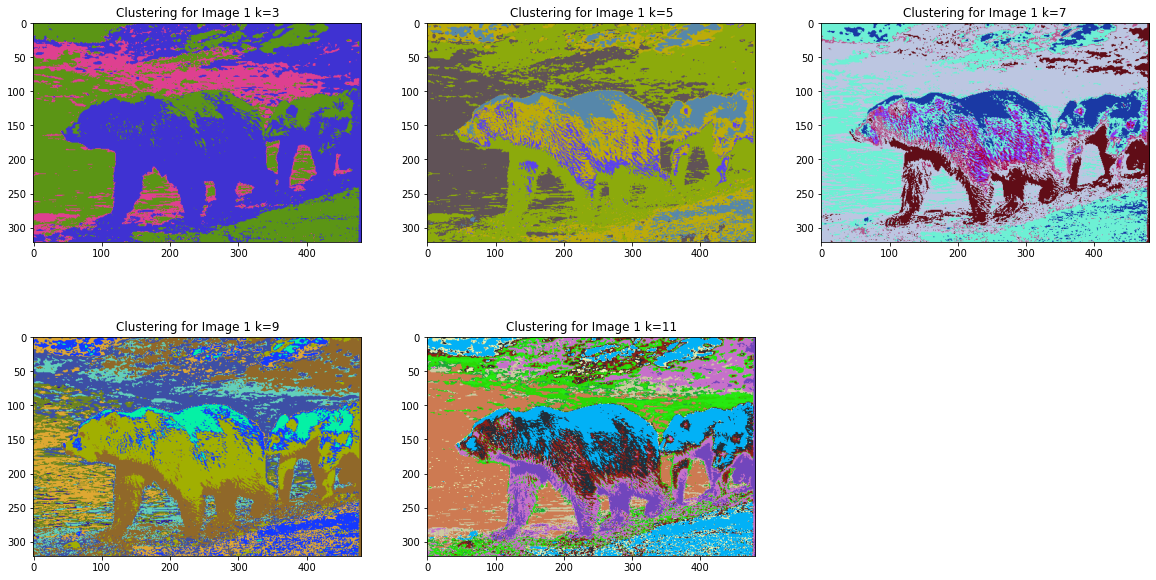

In [ ]:
f, axarr = plt.subplots(2,3,figsize=(20,20))

axarr[0,0].imshow(clustered_imgs[0].reshape(321,481,3))
axarr[0, 0].set_title("Clustering for Image 1 k=3")
axarr[0,1].imshow(clustered_imgs[1].reshape(321,481,3))
axarr[0, 1].set_title("Clustering for Image 1 k=5")
axarr[0,2].imshow(clustered_imgs[2].reshape(321,481,3))
axarr[0, 2].set_title("Clustering for Image 1 k=7")
axarr[1,0].imshow(clustered_imgs[3].reshape(321,481,3))
axarr[1, 0].set_title("Clustering for Image 1 k=9")
axarr[1,1].imshow(clustered_imgs[4].reshape(321,481,3))
axarr[1, 1].set_title("Clustering for Image 1 k=11")
axarr[1, 2].set_visible(False)
plt.subplots_adjust(bottom=0.1,top=0.5)
plt.show()

# F-**measure**

In [ ]:
from sklearn.metrics.cluster import contingency_matrix

def FMeasure(clusters,gt_partitions):
  F=0
  contigencyTable =contingency_matrix(clusters,gt_partitions)
  idx=contigencyTable.argmax(axis=1)
  for i in range(contigencyTable.shape[0]):
        nij = contigencyTable.max(axis=1)[i]
        ni = np.sum(contigencyTable[i])
        ji = contigencyTable[:,idx[i]]
        mji = np.sum(ji)
        F += 2 * nij/(ni+mji)
  return F/contigencyTable.shape[0]



For k =  3  and Ground Truth image number=  1  Fmeasure is  0.3690009688293269
For k =  3  and Ground Truth image number=  2  Fmeasure is  0.43331390255735586
For k =  3  and Ground Truth image number=  3  Fmeasure is  0.357550106899345
For k =  3  and Ground Truth image number=  4  Fmeasure is  0.37974584113606397
For k =  3  and Ground Truth image number=  5  Fmeasure is  0.3799191289960624


For k =  5  and Ground Truth image number=  1  Fmeasure is  0.31716376569652266
For k =  5  and Ground Truth image number=  2  Fmeasure is  0.33403849317441975
For k =  5  and Ground Truth image number=  3  Fmeasure is  0.3071861740925779
For k =  5  and Ground Truth image number=  4  Fmeasure is  0.3294793095331223
For k =  5  and Ground Truth image number=  5  Fmeasure is  0.2910863326310114


For k =  7  and Ground Truth image number=  1  Fmeasure is  0.3816166492919841
For k =  7  and Ground Truth image number=  2  Fmeasure is  0.3704879708506343
For k =  7  and Ground Truth image number= 

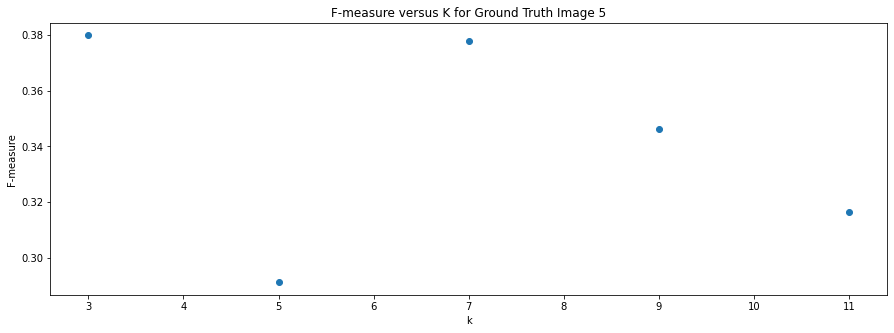

In [ ]:
F = []

for j in range(0,5):
  print("\n")
  for i in range(0,5):
    gt_img = groundTruth[i].reshape(481*321)
    f = FMeasure(Partitions[j],gt_img)
    print("For k = ",means[j]," and Ground Truth image number= ",i+1," Fmeasure is ",f)
  F.append(f)
print("Average of the 5 trials = ",sum(F)/len(F))
plt.scatter(means,F[0:5])
plt.title('F-measure versus K for Ground Truth Image 5');
plt.gcf().set_size_inches(15,5);
plt.xlabel('k');
plt.ylabel('F-measure');


In [ ]:
def entropy(clusters,gt_partitions):
  H=[]
  H_new=0
  SUM=0
  contingencyTable =contingency_matrix(clusters,gt_partitions)
  sums = np.sum(contingencyTable)
  zero_sum=np.zeros(contingencyTable.shape)
  if(~contingencyTable.all()):
    for i in range(contingencyTable.shape[0]):
      for j in range(contingencyTable.shape[1]):
        if(contingencyTable[i][j] == 0):
           contingencyTable[i][j]=1
           zero_sum[i][j]=1       
  for i in range(contingencyTable.shape[0]):
    sum_zero=np.sum(zero_sum[i])
    sumOFrows=np.sum(contingencyTable[i])-(sum_zero)
    for j in range(contingencyTable.shape[1]):
      H_new-=(contingencyTable[i][j]/sumOFrows)*(np.log10(contingencyTable[i][j]/sumOFrows))
    H.append(H_new)  #H(T|C1),H(T|C2)......   
  for k in range(contingencyTable.shape[0]):
    sum_zero1=np.sum(zero_sum[k])
    sumOFrows1=np.sum(contingencyTable[k])-(sum_zero1)
    SUM+=((sumOFrows1/sums)*(H[k]))

  return SUM



For k =  3  and Ground Truth image number=  1  Entropy 1.5808815141550063
For k =  3  and Ground Truth image number=  2  Entropy 1.0394696470776803
For k =  3  and Ground Truth image number=  3  Entropy 1.556118150959105
For k =  3  and Ground Truth image number=  4  Entropy 1.561791436363244
For k =  3  and Ground Truth image number=  5  Entropy 1.769740986194636


For k =  5  and Ground Truth image number=  1  Entropy 2.145571207043817
For k =  5  and Ground Truth image number=  2  Entropy 1.3424116724283541
For k =  5  and Ground Truth image number=  3  Entropy 2.2250573255434
For k =  5  and Ground Truth image number=  4  Entropy 2.2466117770375935
For k =  5  and Ground Truth image number=  5  Entropy 2.639021244380549


For k =  7  and Ground Truth image number=  1  Entropy 1.8832201279978547
For k =  7  and Ground Truth image number=  2  Entropy 1.1956816497290608
For k =  7  and Ground Truth image number=  3  Entropy 1.8735680243604291
For k =  7  and Ground Truth image numbe

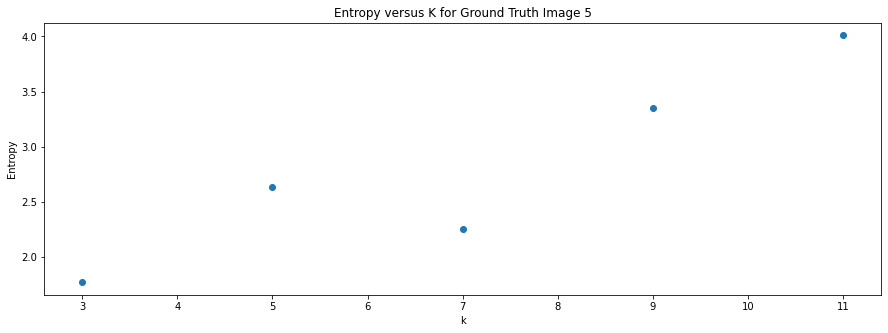

In [ ]:
H = []
for j in range(0,5):
    print("\n")
    for i in range(0,5):
      gt_img = groundTruth[i].reshape(481*321)
      
      h = entropy(Partitions[j],gt_img)
      print("For k = ",means[j]," and Ground Truth image number= ",i+1," Entropy",h)
    H.append(h)
print("Average of the M trials = ",sum(H)/len(H))
plt.scatter(means,H)
plt.title('Entropy versus K for Ground Truth Image 5');
plt.gcf().set_size_inches(15,5);
plt.xlabel('k');
plt.ylabel('Entropy');

# **NN-cut(spectral Clustering)**

In [ ]:
from sklearn.cluster import SpectralClustering
import cv2 as cv
clustered_imgs3=[]
Partitions2=[]

Segmented_Images_resized_spectral = []
for i in range(0,8):
  
  scaled_imag_new=training_imgs[i]/255.0   
  img = np.array(scaled_imag_new)
  res = cv.resize(img,None,fx=.25, fy=.25, interpolation = cv.INTER_CUBIC)
  pic_new = res.reshape(res.shape[0]*res.shape[1], res.shape[2])

  spectraln = SpectralClustering(n_clusters=5,affinity='nearest_neighbors',n_neighbors=5).fit(pic_new)

  clustered_imgs2 = ColorImages(spectraln.labels_,res,5)
  Partitions2.append(spectraln.labels_)  #storing clusters for each k value per image [cluster for image(0) k=3,cluster for image(0) k=5,....]
  clustered_imgs3.append(clustered_imgs2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


# **Big Picture**

Text(0.5, 1.0, 'Ground Truth for Image 1 ')

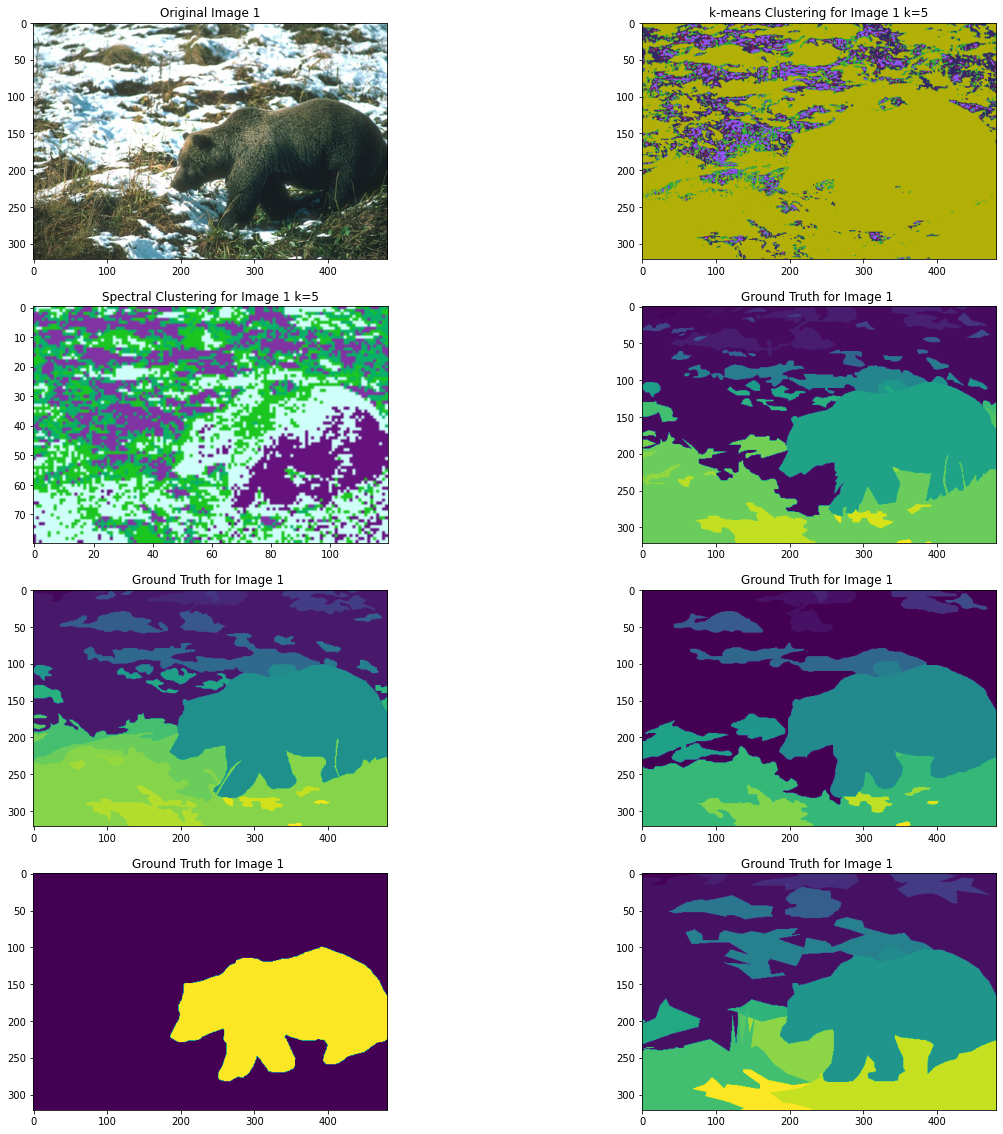

In [ ]:
f, axarr = plt.subplots(4,2,figsize=(20,20))

axarr[0, 0].imshow(training_imgs[2].reshape(321,481,3))
axarr[0, 0].set_title("Original Image 1")
axarr[0, 1].imshow(clustered_imgs[11].reshape(321,481,3))
axarr[0, 1].set_title("k-means Clustering for Image 1 k=5")
axarr[1, 0].imshow(clustered_imgs3[2].reshape(80,120,3))
axarr[1, 0].set_title("Spectral Clustering for Image 1 k=5")

axarr[1, 1].imshow(groundTruth[11])
axarr[1, 1].set_title("Ground Truth for Image 1 ")
axarr[2, 0].imshow(groundTruth[12])
axarr[2, 0].set_title("Ground Truth for Image 1 ")
axarr[2, 1].imshow(groundTruth[13])
axarr[2, 1].set_title("Ground Truth for Image 1 ")
axarr[3, 0].imshow(groundTruth[14])
axarr[3, 0].set_title("Ground Truth for Image 1 ")
axarr[3, 1].imshow(groundTruth[15])
axarr[3, 1].set_title("Ground Truth for Image 1 ")


Text(0.5, 1.0, 'Ground Truth for Image 2 ')

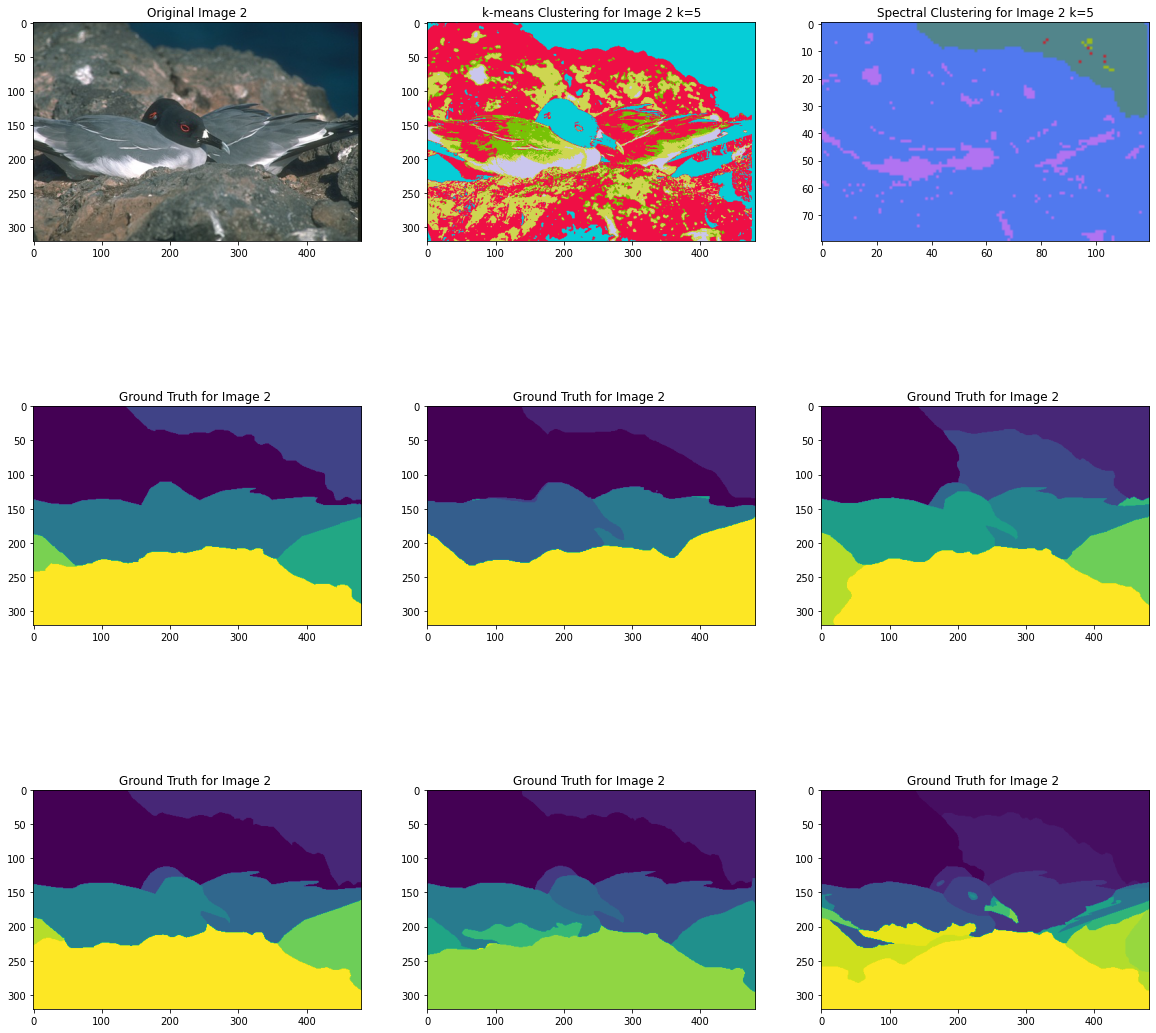

In [ ]:
f, axarr = plt.subplots(3,3,figsize=(20,20))

axarr[0, 0].imshow(training_imgs[3].reshape(321,481,3))
axarr[0, 0].set_title("Original Image 2")
axarr[0, 1].imshow(clustered_imgs[16].reshape(321,481,3))
axarr[0, 1].set_title("k-means Clustering for Image 2 k=5")
axarr[0, 2].imshow(clustered_imgs3[3].reshape(80,120,3))
axarr[0, 2].set_title("Spectral Clustering for Image 2 k=5")
axarr[1, 0].imshow(groundTruth[16])
axarr[1, 0].set_title("Ground Truth for Image 2 ")
axarr[1, 1].imshow(groundTruth[17])
axarr[1, 1].set_title("Ground Truth for Image 2 ")
axarr[1, 2].imshow(groundTruth[18])
axarr[1, 2].set_title("Ground Truth for Image 2 ")
axarr[2, 0].imshow(groundTruth[19])
axarr[2, 0].set_title("Ground Truth for Image 2 ")
axarr[2, 1].imshow(groundTruth[20])
axarr[2, 1].set_title("Ground Truth for Image 2 ")
axarr[2, 2].imshow(groundTruth[21])
axarr[2, 2].set_title("Ground Truth for Image 2 ")


Text(0.5, 1.0, 'Ground Truth for Image 3 ')

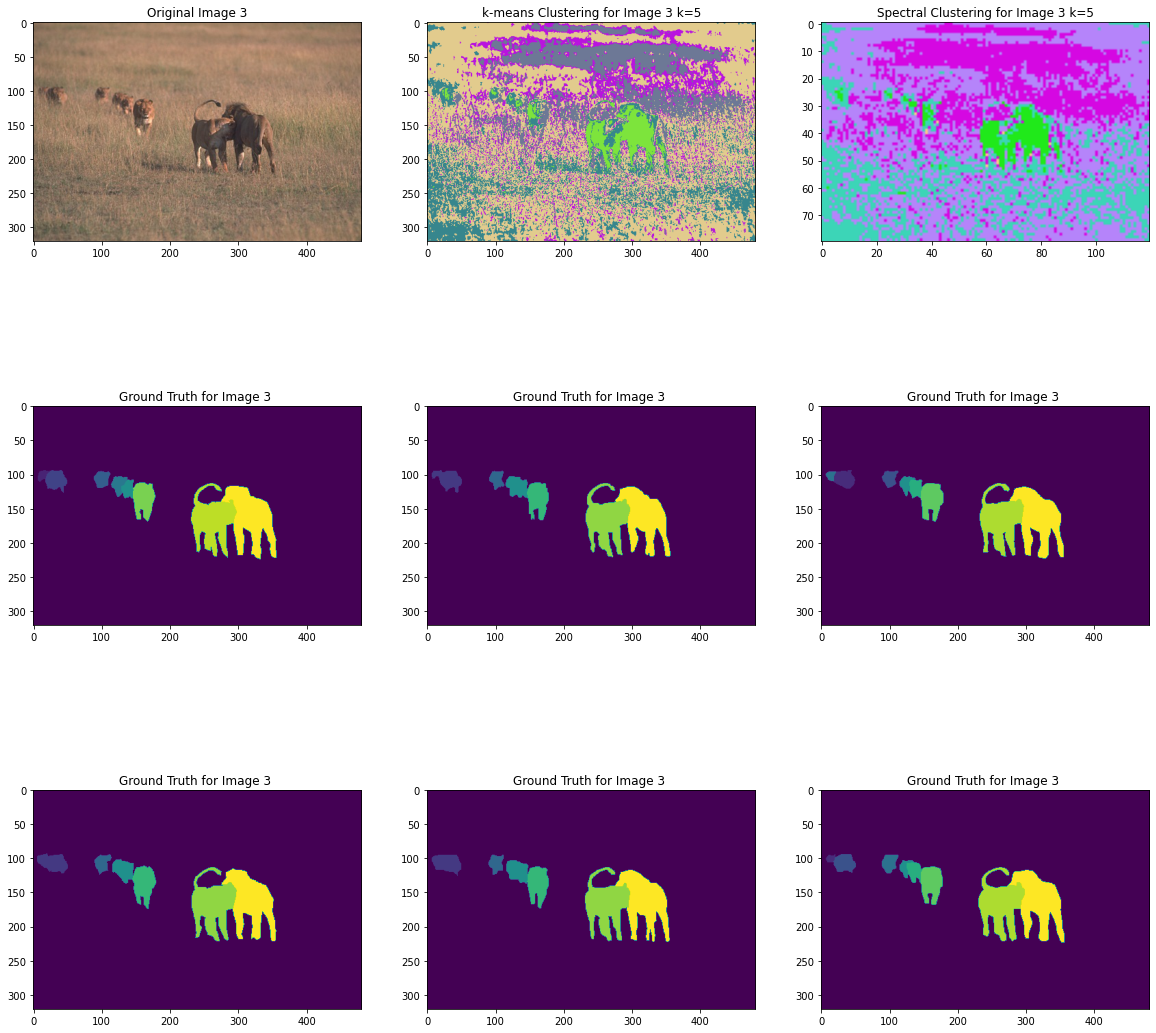

In [ ]:
f, axarr = plt.subplots(3,3,figsize=(20,20))

axarr[0, 0].imshow(training_imgs[5].reshape(321,481,3))
axarr[0, 0].set_title("Original Image 3")
axarr[0, 1].imshow(clustered_imgs[26].reshape(321,481,3))
axarr[0, 1].set_title("k-means Clustering for Image 3 k=5")
axarr[0, 2].imshow(clustered_imgs3[5].reshape(80,120,3))
axarr[0, 2].set_title("Spectral Clustering for Image 3 k=5")
axarr[1, 0].imshow(groundTruth[29])
axarr[1, 0].set_title("Ground Truth for Image 3 ")
axarr[1, 1].imshow(groundTruth[30])
axarr[1, 1].set_title("Ground Truth for Image 3 ")
axarr[1, 2].imshow(groundTruth[31])
axarr[1, 2].set_title("Ground Truth for Image 3 ")
axarr[2, 0].imshow(groundTruth[32])
axarr[2, 0].set_title("Ground Truth for Image 3 ")
axarr[2, 1].imshow(groundTruth[33])
axarr[2, 1].set_title("Ground Truth for Image 3 ")
axarr[2, 2].imshow(groundTruth[34])
axarr[2, 2].set_title("Ground Truth for Image 3 ")


Text(0.5, 1.0, 'Ground Truth for Image 4 ')

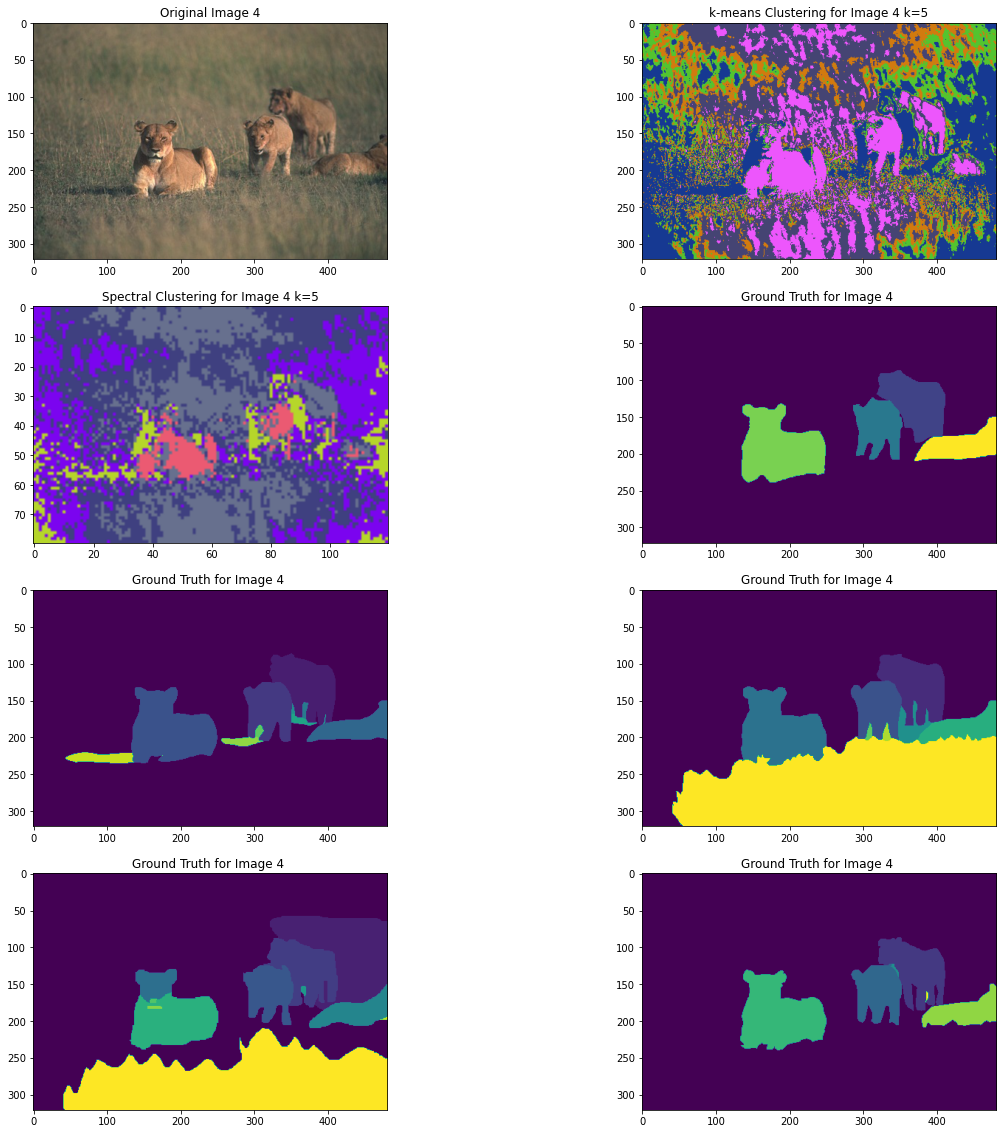

In [ ]:
f, axarr = plt.subplots(4,2,figsize=(20,20))

axarr[0, 0].imshow(training_imgs[6].reshape(321,481,3))
axarr[0, 0].set_title("Original Image 4")
axarr[0, 1].imshow(clustered_imgs[31].reshape(321,481,3))
axarr[0, 1].set_title("k-means Clustering for Image 4 k=5")
axarr[1, 0].imshow(clustered_imgs3[6].reshape(80,120,3))
axarr[1, 0].set_title("Spectral Clustering for Image 4 k=5")

axarr[1, 1].imshow(groundTruth[35])
axarr[1, 1].set_title("Ground Truth for Image 4 ")
axarr[2, 0].imshow(groundTruth[36])
axarr[2, 0].set_title("Ground Truth for Image 4 ")
axarr[2, 1].imshow(groundTruth[37])
axarr[2, 1].set_title("Ground Truth for Image 4 ")
axarr[3, 0].imshow(groundTruth[38])
axarr[3, 0].set_title("Ground Truth for Image 4 ")
axarr[3, 1].imshow(groundTruth[39])
axarr[3, 1].set_title("Ground Truth for Image 4 ")


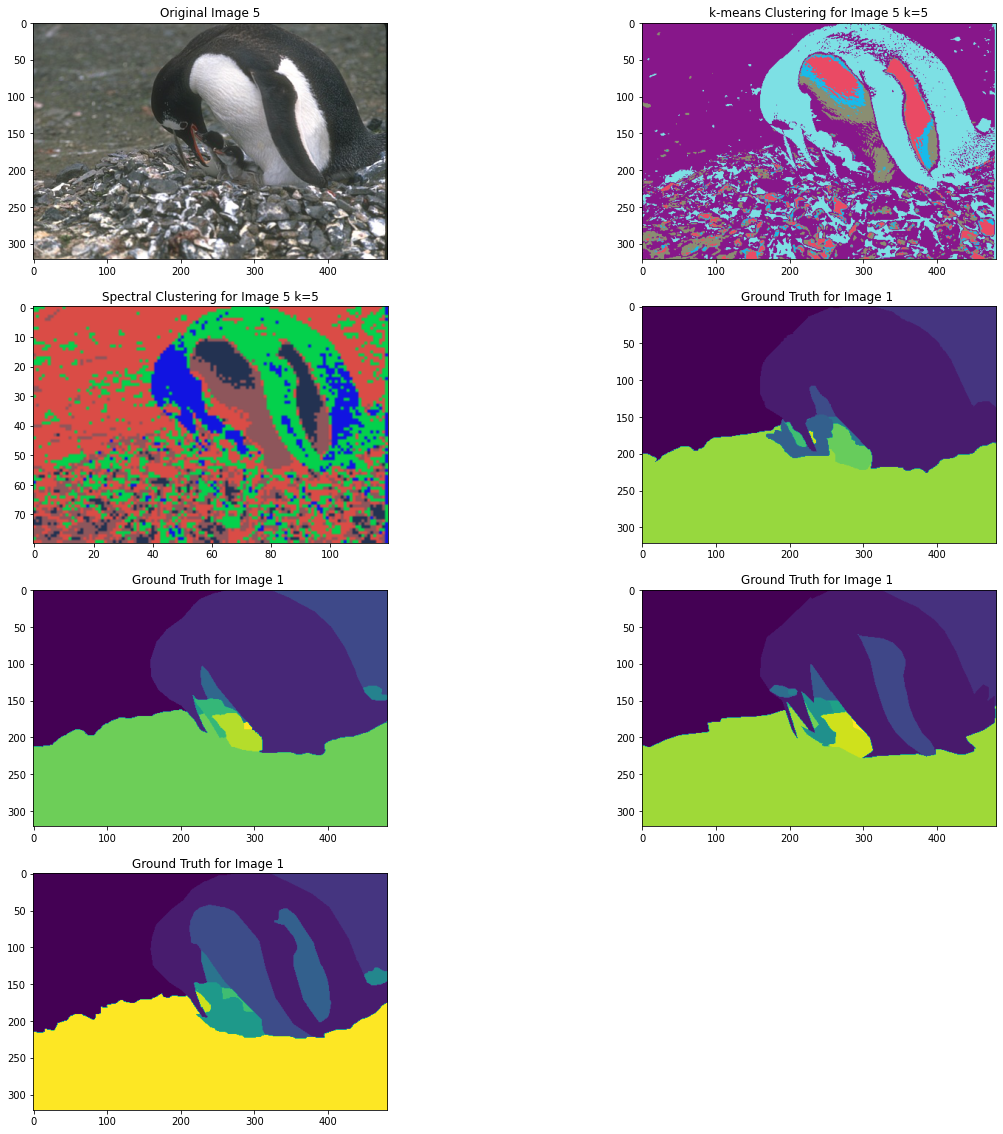

In [ ]:
f, axarr = plt.subplots(4,2,figsize=(20,20))

axarr[0, 0].imshow(training_imgs[7].reshape(321,481,3))
axarr[0, 0].set_title("Original Image 5")
axarr[0, 1].imshow(clustered_imgs[36].reshape(321,481,3))
axarr[0, 1].set_title("k-means Clustering for Image 5 k=5")
axarr[1, 0].imshow(clustered_imgs3[7].reshape(80,120,3))
axarr[1, 0].set_title("Spectral Clustering for Image 5 k=5")

axarr[1, 1].imshow(groundTruth[40])
axarr[1, 1].set_title("Ground Truth for Image 1 ")
axarr[2, 0].imshow(groundTruth[41])
axarr[2, 0].set_title("Ground Truth for Image 1 ")
axarr[2, 1].imshow(groundTruth[42])
axarr[2, 1].set_title("Ground Truth for Image 1 ")
axarr[3, 0].imshow(groundTruth[43])
axarr[3, 0].set_title("Ground Truth for Image 1 ")

axarr[3, 1].set_visible(False)


## **Extra: Spatial Layout**

In [ ]:
spatial_train_set=np.arange(154401*300*5).reshape(154401*300,5)
img_mat = np.arange((321*481*300) *3).reshape(((321*481*300),3))
spatial_layout = []
reshape_imgs = []
for i in range(5):
  for j in range(321):
    for k in range(481):
      spatial_layout.append([j,k])

for l in range(14,19):
  scaled_image = training_imgs[l]   
  pic_n = scaled_image.reshape(scaled_image.shape[0]*scaled_image.shape[1],scaled_image.shape[2])
  for i in range(len(pic_n)):
    reshape_imgs.append(pic_n[i])
spatial_train_set =np.hstack([reshape_imgs,spatial_layout])

In [ ]:
from random import randint
def ColorSpatialImages(clusters,data,cluster_num):
    clusterised_mat= np.zeros(data.shape,dtype=np.uint8)
    colors = []
    for i in range(cluster_num):
        colors.append(np.array([randint(0, 255),randint(0, 255),randint(0, 255)]))
    for i in range(data.shape[0]):
        clusterised_mat[i] = colors[clusters[i]]
    return clusterised_mat

In [ ]:
clusterised_imgs = []
clusterings = []
for k in range(3,12,2):  
    for count in range(5):
        #get an image
        image = spatial_train_set[(321*481)*count:(321*481)+((321*481)*count)]        # with spatial layout (locations encoded)
        without_spatial_image = spatial_train_set[(321*481)*count:(321*481)+((321*481)*count),0:3]   # without spatial layout (locations encoded) 
        pic_n= image.reshape(321,481,5)

        model_labels = Kmeans(k,pic_n,0.0001,300)
        clusterings.append(model_labels)
        clusterised_imgs.append(ColorSpatialImages(model_labels,without_spatial_image,k))

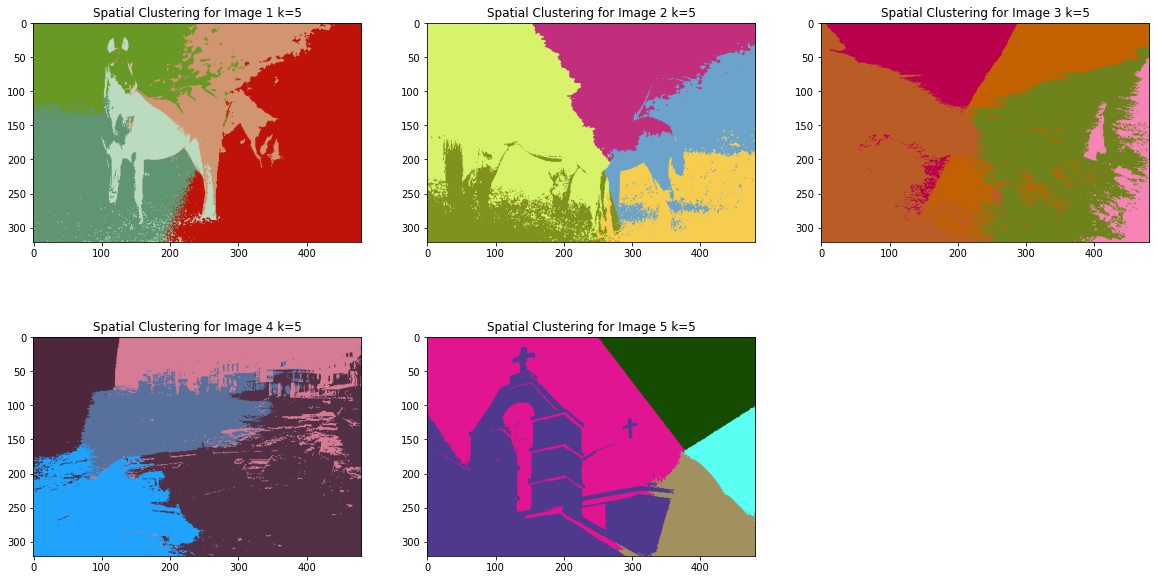

In [ ]:
f, axarr = plt.subplots(2,3,figsize=(20,20))

axarr[0, 0].imshow(clusterised_imgs[5].reshape(321,481,3))
axarr[0, 0].set_title("Spatial Clustering for Image 1 k=5")
axarr[0, 1].imshow(clusterised_imgs[6].reshape(321,481,3))
axarr[0, 1].set_title("Spatial Clustering for Image 2 k=5")
axarr[0, 2].imshow(clusterised_imgs[7].reshape(321,481,3))
axarr[0, 2].set_title("Spatial Clustering for Image 3 k=5")
axarr[1, 0].imshow(clusterised_imgs[8].reshape(321,481,3))
axarr[1, 0].set_title("Spatial Clustering for Image 4 k=5")
axarr[1, 1].imshow(clusterised_imgs[9].reshape(321,481,3))
axarr[1, 1].set_title("Spatial Clustering for Image 5 k=5")
axarr[1, 2].set_visible(False)
plt.subplots_adjust(bottom=0.1,top=0.5)
plt.show()
